# This notebook demonstrates the workflow of using Landsat imagery from Microsoft Planetary Computer to map forest disturbance (logging) patterns in Oregon

The workflow includes the following steps:
1. Find all the Landsat scenes between 1984 and 2020 from Planetary Computer in Oregon which has less than 5% cloud cover
2. Create a RasterCollection from all the scenes
3. Use normalized burn ratio (NBR) to extract disturbed areas from the Landsat images
4. Use Landtrendr algorithm to analyze the trend of NBR over time
5. Find the year that abrupt decrease in forest cover happened

#### Estimated running time: 30 minutes

## Find data and create RasterCollection from Microsoft Planetary Computer

### Import relevant modules

In [12]:
import arcpy
from arcpy import AIO

### Find data and create RasterCollection from Microsoft Planetary Computer

In [13]:
# Create an AIO object from the cloud storage connection file for data access
a = AIO(r'C:\acsFiles\esrims_pc_landsat-c2.acs')

In [85]:
# Define the query to search for images
# First query to find all images except Landsat-7
query1 = {
    "collections": ["landsat-c2-l2"],
    "bbox": [-122.3508195, 44.9125938, -122.3508194, 44.9125939],
    "query": {"landsat:wrs_row": {"eq": "029"}, "landsat:wrs_path": {"eq": "046"}, "eo:cloud_cover": {"lt": 5}, 'platform': {"in": ['landsat-4', 'landsat-5', 'landsat-8', 'landsat9']}},
    "datetime": "1984-01-01/2020-12-31",
    "limit": 1000,
          }
# Second query to find Landsat-7 images collected before 2003
query2 = {
    "collections": ["landsat-c2-l2"],
    "bbox": [-122.3508195, 44.9125938, -122.3508194, 44.9125939],
    "query": {"landsat:wrs_row": {"eq": "029"}, "landsat:wrs_path": {"eq": "046"}, "eo:cloud_cover": {"lt": 5}, 'platform': {"in": ['landsat-7']}},
    "datetime": "1984-01-01/2002-12-31",
    "limit": 1000,
          }

In [86]:
%%time
# Create RasterCollections from the queries and combine them
rc1 = arcpy.ia.RasterCollection.fromSTACAPI(stac_api="https://planetarycomputer.microsoft.com/api/stac/v1",
                                  query=query1,
                                  attribute_dict={
                                      "Name":"id",
                                      "Cloud Cover":"eo:cloud_cover",
                                      "StdTime":"datetime",
                                      "Platform":"platform",
                                      "Spatial Reference":"proj:epsg",
                                      "Extent": "bbox",
                                    })
rc2 = arcpy.ia.RasterCollection.fromSTACAPI(stac_api="https://planetarycomputer.microsoft.com/api/stac/v1",
                                  query=query2,
                                  attribute_dict={
                                      "Name":"id",
                                      "Cloud Cover":"eo:cloud_cover",
                                      "StdTime":"datetime",
                                      "Platform":"platform",
                                      "Spatial Reference":"proj:epsg",
                                      "Extent": "bbox",
                                    })
rc = rc1.merge(rc2)

# Add a Variable field to the RasterCollection called 'landsat'
rc = rc.addField('Variable', 'landsat')

Wall time: 1min 10s


## Data processing

### Define NBR function

In [88]:
# Define the function to clip images to study area and calculate Normalized Burn Ratio 
def nbr_func(item):
    # Define processing AOI
    coordinates = [[-122.6592860, 44.7533393], [-122.1914706, 44.7533393], [-122.1914706, 45.0076361], [-122.6592860, 45.0076361]]
    array = arcpy.Array([arcpy.Point(x, y) for x, y in coordinates])
    polygon_geometry = arcpy.Polygon(array, arcpy.SpatialReference(4326))
    
    # Define band designations for each sesnor
    if item['Platform'] == 'landsat-8' or item['Platform'] == 'landsat-9':
        nir = 5
        swir = 7
    else:
        nir = 4
        swir = 7

    raster = item['Raster']
    
    # Clip input to AOI
    clip = arcpy.ia.Clip(raster, aoi = polygon_geometry)
    
    # Calculate NBR
    nbr = arcpy.ia.NBR(clip, nir_band_id = nir, swir_band_id = swir)
    
    return {"raster": nbr, 'Name': item['Name'], "StdTime": item['StdTime'], 'Variable': item['Variable']}

### Perform calculation on each image in the RasterCollection and convert the RasterCollection to a multidimensional raster

In [89]:
# Apply the nbr function to each image in the RasterCollection
rc_nbr = rc.map(nbr_func)
# Convert the RasterCollection to a multidimensional raster
mdim_nbr = rc_nbr.toMultidimensionalRaster(variable_field_name = 'Variable', dimension_field_names = 'StdTime')

### Apply the Landtrendr algorithm to analyze trends in the data

In [90]:
%%time
# Apply Landtrendr GP tool
landtrendr_nbr = arcpy.ia.AnalyzeChangesUsingLandTrendr(mdim_nbr)
# Optionally save the output
# landtrendr_nbr.save(r'C:\temp\oregon_nbr_landtrendr.crf')

Wall time: 29min 29s


### Detect changes corresponding to abrupt decrease in forest cover (logging)

In [91]:
%%time
# Use Detect Change Using Change Analysis Raster GP tool to detect abrupt changes
abrupt_decrease = arcpy.ia.DetectChangeUsingChangeAnalysisRaster(landtrendr_nbr, 
                                                                 change_type = 'TIME_OF_EARLIEST_CHANGE', 
                                                                 max_number_changes = 1, 
                                                                 change_direction = 'DECREASE', 
                                                                 filter_by_duration = True, 
                                                                 min_duration = 0, 
                                                                 max_duration = 4, 
                                                                 filter_by_magnitude = True, 
                                                                 min_magnitude = 0.2)
# Optionally save the output
# abrupt_decrease.save(r'C:\temp\oregon_nbr_decrease.crf')

Wall time: 34.4 s


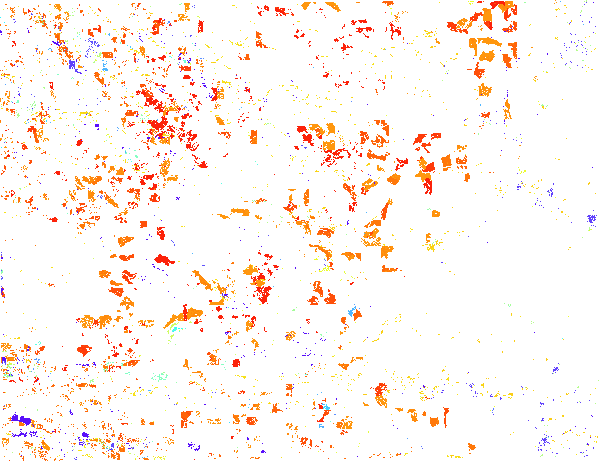

In [92]:
# Visualize the result
abrupt_decrease